# Sen12MS Generate Subset Per Region (Scene or ROI)  

Author: Taeil Goh

In [1]:
!ls /scratch/crguest/data

resisc45  sen12ms_small


This notebook is to generate subset of data and visualize them for validation purpose.
The goal is to generate smaller set for pre-training while making sure, 

- positive pairs are collected from s1 and s2 sensor. 
- negative pairs are does not overwrap writh positive pairs. 

For these reason, one patch will be selected from each region for simpliication purpose. 


In [2]:
root = "/storage/sen12ms_x"
output_dir = "/scratch/crguest/data/sen12ms_small/"

seasons = !ls $root
seasons

['ROIs1158_spring', 'ROIs1868_summer', 'ROIs1970_fall', 'ROIs2017_winter']

In [3]:
import pandas as pd
import glob
import os, sys
import shutil 

## Iterate through files

In [4]:
tiles = pd.DataFrame(glob.glob(os.path.join(root,'*','*','*.tif')), columns=["path"])
split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
tiles = tiles.join(split)

In [5]:
tiles.head()

,path,seed,season,sensor,region,tile
0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p404.tif
1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p798.tif
2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p810.tif
3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p186.tif
4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p510.tif


In [6]:
# of patches: 180662
tiles.shape[0]/3

180662.0

`tiles` dataframe contains the path. 

In [7]:
seed_seasons = [('ROIs1158', 'spring'), ('ROIs1868', 'summer'), ('ROIs1970', 'fall'), ('ROIs2017', 'winter')]

sub_datasets = []
for seed_season in seed_seasons:
    temp_df = tiles[(tiles["seed"] == seed_season[0]) & (tiles["season"] == seed_season[1]) & (tiles["sensor"] == "s1")]
    temp_df = temp_df[["seed","season","region","tile"]]
    temp_df = temp_df.groupby("region").sample(n=1, random_state=42)
    print(f"sampled {len(temp_df)} patches from {seed_season[0]} {seed_season[1]}") 
    
    sub_datasets.append(temp_df)

sub_datasets_indices = pd.concat(sub_datasets, ignore_index=True)

sampled 56 patches from ROIs1158 spring
sampled 65 patches from ROIs1868 summer
sampled 85 patches from ROIs1970 fall
sampled 46 patches from ROIs2017 winter


In [8]:
final_df = pd.merge(sub_datasets_indices, tiles, how='left', left_on=["seed", "season", "region", "tile"], right_on=["seed", "season", "region", "tile"])

In [24]:
from pathlib import Path

for i in final_df.index:
    try:
        tile = final_df.tile[i].split(".")[0]
        sub_dir = os.path.join(output_dir, f"{tile}_{final_df.season[i]}")
        if not os.path.exists(sub_dir):
            os.makedirs(sub_dir)
        
        shutil.copy(final_df.path[i], sub_dir)
    except IOError as e:
        print("Unable to copy file. %s" % e)
    except:
        print("Unexpected error:", sys.exc_info())

In [10]:
len(final_df)

756

In [13]:
756 / 256

2.953125

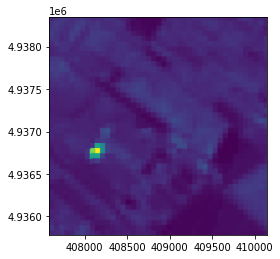

<AxesSubplot:>

In [19]:
import rasterio
from rasterio.plot import show

sample = "/scratch/crguest/data/sen12ms_small/p291.tif_spring/ROIs1158_spring_s2_121_p291.tif"
img = rasterio.open(sample)
show(img)